In [1]:
import pandas as pd
import scipy.special
import math
from matplotlib.pyplot import plot,scatter
import statistics
from sklearn.cluster import KMeans
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np

nba 2000 Indiana Pacers -5.631077324079996 Portland Trail Blazers -0.6727889222956657
nba 2001 Denver Nuggets -5.610862267082693 Philadelphia 76ers -0.8176430583816466
nba 2002 New Jersey Nets -4.228697343452214 Charlotte Hornets -0.3833945185620029
nba 2003 Chicago Bulls -8.914917337805443 Philadelphia 76ers -0.8194550516932287
nba 2004 Dallas Mavericks -7.648357773084604 Orlando Magic -0.7169669908971381
nba 2005 San Antonio Spurs -6.846028544961502 Phoenix Suns -0.5381008504620488
nba 2006 Orlando Magic -4.676365219094853 Houston Rockets -0.242356146473005
nba 2007 Golden State Warriors -5.661837441662076 Detroit Pistons -0.45693446426285533
nba 2008 Utah Jazz -8.016702264422117 Orlando Magic -0.3705975723544924
nba 2009 Utah Jazz -5.966234135382336 Minnesota Timberwolves -0.3709111895374232
nba 2010 Charlotte Bobcats -5.736040780142513 Philadelphia 76ers -0.2968816134271257
nba 2011 Washington Wizards -5.555142475073601 Sacramento Kings -0.3709111895374232
nba 2012 Utah Jazz -4.595

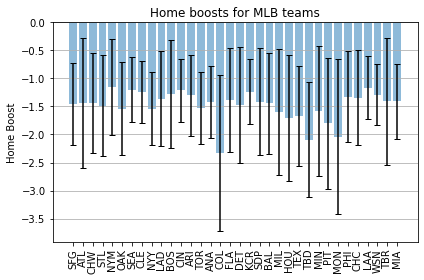

In [10]:
years = range(2000, 2021)
leagues = ["nba", "mlb"] # TODO: add other leagues

def get_home_boost(total_pct, home_wins, home_games):
    prob = 0
    for wins in range(math.ceil(home_wins), home_games + 1):
        prob += scipy.special.binom(home_games, wins) * total_pct ** wins * (1-total_pct) ** (home_games - wins)
        
    return math.log(prob)

teamWinPct= {}
teamHomeBoosts={}
for league in leagues:
    teamHomeBoosts[league]={}
    teamWinPct[league]={}
    for year in years:
        min_team = ""
        min_boost = 0
        max_team = ""
        max_boost = -10
        
        standings = pd.read_csv("data/" + league + "/" + str(year) + ".csv") 
        for (team, home, road) in zip(standings["Team"], standings["Home"], standings["Road"]):
            [home_wins, home_losses] = [int(games) for games in home.split("-")]
            [road_wins, road_losses] = [int(games) for games in road.split("-")]

            total_wins = home_wins + road_wins
            total_games = total_wins + home_losses + road_losses

            total_pct = total_wins / total_games
            
            

            home_games = home_wins + home_losses
            
            boost = get_home_boost(total_pct, home_wins, home_games)
            
            if(team not in teamHomeBoosts[league]):
                teamHomeBoosts[league][team]=[]
                teamWinPct[league][team] = []
            teamHomeBoosts[league][team].append(boost)
            
            teamWinPct[league][team].append(total_pct)
            
            if boost < min_boost:
                min_team = team
                min_boost = boost
            if boost > max_boost:
                max_team = team
                max_boost = boost
        print(league, year, min_team, min_boost, max_team, max_boost)
        
nba = teamHomeBoosts["nba"]
nba_labels = []
nba_means = []
nba_std_devs = []
for key in nba:
    nba_labels.append(key)
    nba_means.append(statistics.mean(nba[key]))
    nba_std_devs.append(statistics.pstdev(nba[key]))
print("NBA mean: " + str(statistics.mean(nba_means)))
    
mlb = teamHomeBoosts["mlb"]
mlb_labels = []
mlb_means = []
mlb_std_devs = []
for key in mlb:
    mlb_labels.append(key)
    mlb_means.append(statistics.mean(mlb[key]))
    mlb_std_devs.append(statistics.pstdev(mlb[key]))
print("MLB mean: " + str(statistics.mean(mlb_means)))



#References https://pythonforundergradengineers.com/python-matplotlib-error-bars.html
fig,ax2 = plt.subplots()

# x_pos1 = np.arange(len(nba_labels))
# ax1.bar(x_pos1, nba_means, yerr=nba_std_devs, align='center', alpha=0.5, ecolor='black', capsize=3)
# ax1.set_ylabel('Home Boost')
# ax1.set_xticks(x_pos1)
# ax1.set_xticklabels(nba_labels)
# plt.xticks(rotation='vertical')
# ax1.set_title('Home boosts for NBA teams')
# ax1.yaxis.grid(True)

x_pos2 = np.arange(len(mlb_labels))
ax2.bar(x_pos2, mlb_means, yerr=mlb_std_devs, align='center', alpha=0.5, ecolor='black', capsize=3)
ax2.set_ylabel('Home Boost')
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(mlb_labels)
plt.xticks(rotation='vertical')
ax2.set_title('Home boosts for MLB teams')
ax2.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('mlb_plot')
plt.show()

    

nfl 2000 Arizona Cardinals -1.7359465419824767 New Orleans Saints -0.036686319297574564
nfl 2001 Minnesota Vikings -2.6845894198294498 Carolina Panthers 0.0
nfl 2002 Miami Dolphins -2.625750466669077 Cleveland Browns -0.08042257473142743
nfl 2003 Seattle Seahawks -3.7600290339658846 New York Giants -0.10548598468324917
nfl 2004 Arizona Cardinals -1.9847931707052622 Green Bay Packers -0.1478146647874336
nfl 2005 Baltimore Ravens -3.3236384462947344 New Orleans Saints -0.21063104625167084
nfl 2006 Indianapolis Colts -2.301456579614247 New England Patriots -0.12082989368706583
nfl 2007 Pittsburgh Steelers -2.002171116413511 New England Patriots 0.0
nfl 2008 Carolina Panthers -2.301456579614247 Detroit Lions 0.0
nfl 2009 New England Patriots -3.7600290339658846 St. Louis Rams 0.0
nfl 2010 Green Bay Packers -2.002171116413511 Miami Dolphins -0.01007316011156733
nfl 2011 Baltimore Ravens -2.301456579614247 Philadelphia Eagles -0.15610571466306167
nfl 2012 Seattle Seahawks -2.9975475955312856

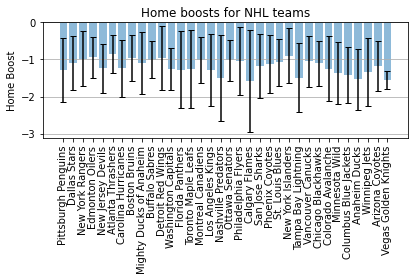

In [11]:
other_years = range(2000, 2020)
other_leagues = ["nfl", "nhl"] # TODO: add other leagues

for league in other_leagues:
    teamHomeBoosts[league]={}
    teamWinPct[league] = {}
    for year in other_years:
        if league == "nhl" and year == 2005:
            continue
        
        min_team = ""
        min_boost = 0
        max_team = ""
        max_boost = -10
        
        standings = pd.read_csv("data/" + league + "/" + str(year) + ".csv") 
        for (team, games, wins, home_games, home_wins) in zip(standings["Team"], standings["Games"], standings["Wins"], standings["Home Games"], standings["Home Wins"]):
            total_pct = wins / games
            
            boost = get_home_boost(total_pct, home_wins, home_games)
            
            if(team not in teamHomeBoosts[league]):
                teamHomeBoosts[league][team]=[]
                teamWinPct[league][team] = []
                
            teamHomeBoosts[league][team].append(boost)
            teamWinPct[league][team].append(total_pct)
            
            
            if boost < min_boost:
                min_team = team
                min_boost = boost
            if boost > max_boost:
                max_team = team
                max_boost = boost
        print(league, year, min_team, min_boost, max_team, max_boost)
        
nfl = teamHomeBoosts["nfl"]
nfl_labels = []
nfl_means = []
nfl_std_devs = []
for key in nfl:
    nfl_labels.append(key)
    nfl_means.append(statistics.mean(nfl[key]))
    nfl_std_devs.append(statistics.pstdev(nfl[key]))
print("NFL mean: " + str(statistics.mean(nfl_means)))
    
nhl = teamHomeBoosts["nhl"]
nhl_labels = []
nhl_means = []
nhl_std_devs = []
for key in nhl:
    nhl_labels.append(key)
    nhl_means.append(statistics.mean(nhl[key]))
    nhl_std_devs.append(statistics.pstdev(nhl[key]))
print("NHL mean: " + str(statistics.mean(nhl_means)))
    
nba = teamHomeBoosts["nba"]
nba_labels = []
nba_means = []
nba_std_devs = []
for key in nba:
    nba_labels.append(key)
    nba_means.append(statistics.mean(nba[key]))
    nba_std_devs.append(statistics.pstdev(nba[key]))
    
mlb = teamHomeBoosts["mlb"]
mlb_labels = []
mlb_means = []
mlb_std_devs = []
for key in mlb:
    mlb_labels.append(key)
    mlb_means.append(statistics.mean(mlb[key]))
    mlb_std_devs.append(statistics.pstdev(mlb[key]))
        
        

#References https://pythonforundergradengineers.com/python-matplotlib-error-bars.html
fig,ax2 = plt.subplots()

# x_pos1 = np.arange(len(nfl_labels))
# ax1.bar(x_pos1, nfl_means, yerr=nfl_std_devs, align='center', alpha=0.5, ecolor='black', capsize=3)
# ax1.set_ylabel('Home Boost')
# ax1.set_xticks(x_pos1)
# ax1.set_xticklabels(nfl_labels)
# plt.xticks(rotation='vertical')
# ax1.set_title('Home boosts for NFL teams')
# ax1.yaxis.grid(True)

x_pos2 = np.arange(len(nhl_labels))
ax2.bar(x_pos2, nhl_means, yerr=nhl_std_devs, align='center', alpha=0.5, ecolor='black', capsize=3)
ax2.set_ylabel('Home Boost')
ax2.set_xticks(x_pos2)
ax2.set_xticklabels(nhl_labels)
plt.xticks(rotation='vertical')
ax2.set_title('Home boosts for NHL teams')
ax2.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('nhl_plot')
plt.show()

    

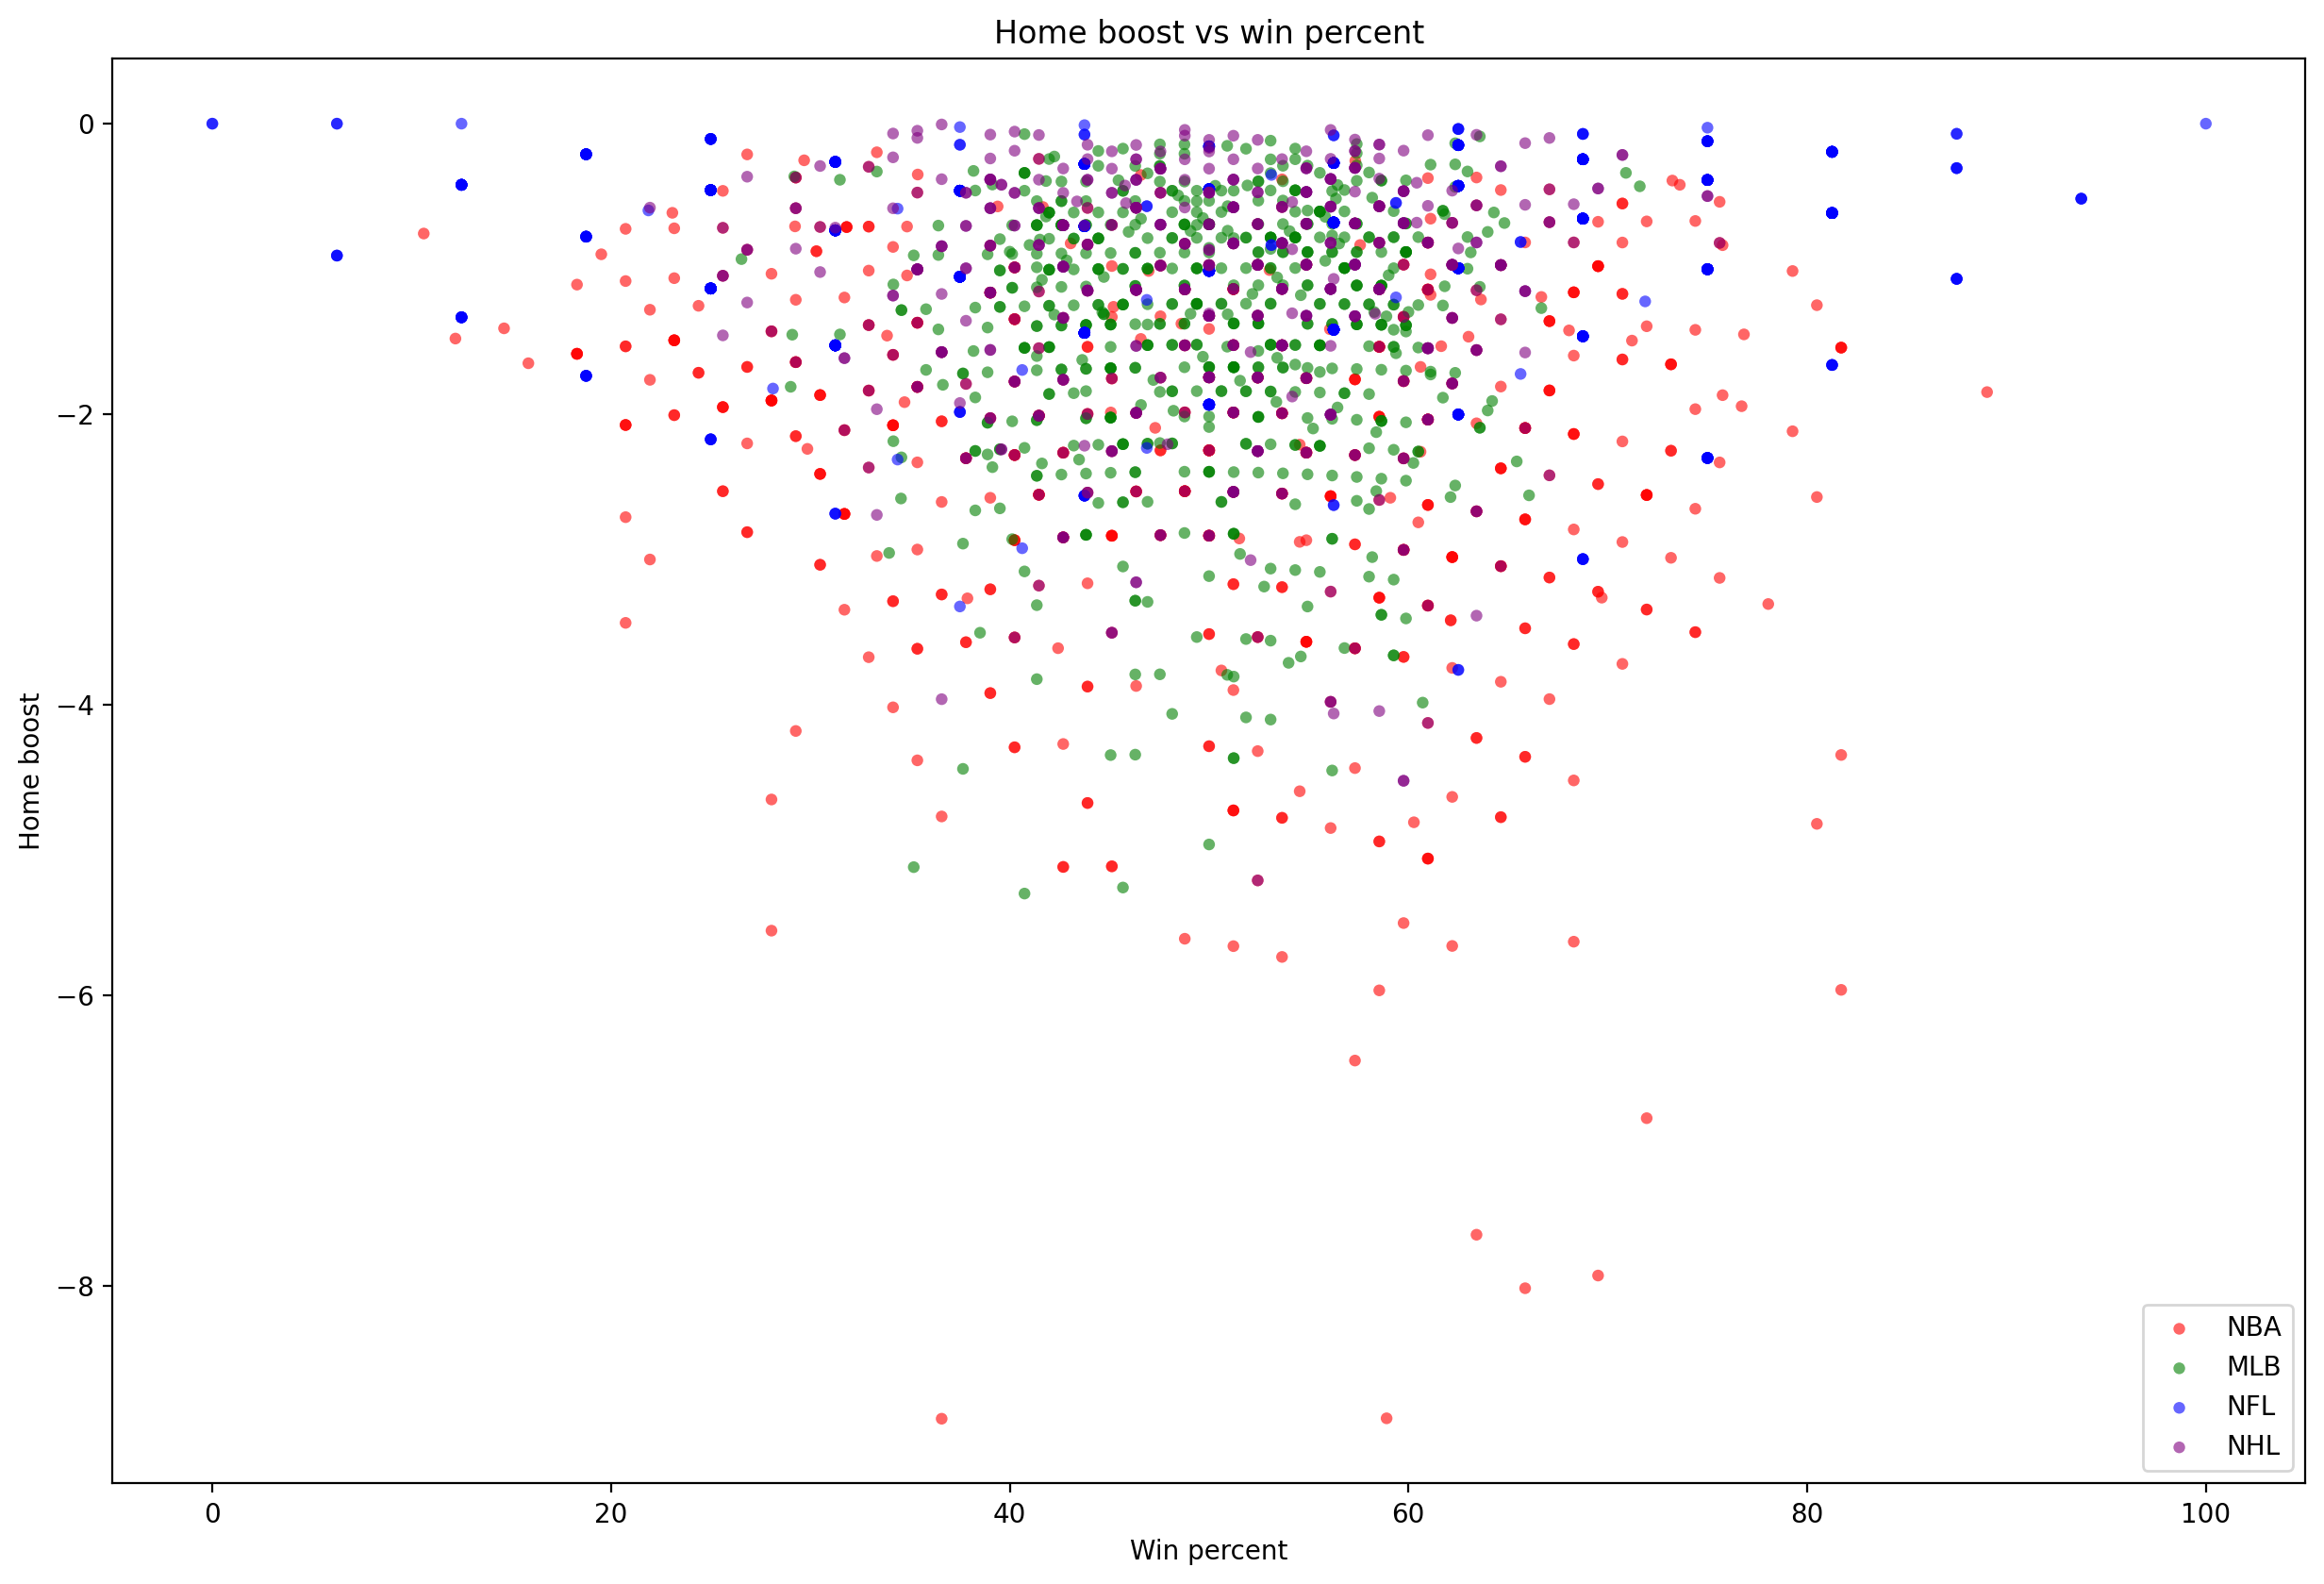

In [28]:
all_home_boosts = { "nba": [], "mlb": [], "nfl": [], "nhl": [] }
all_win_pcts = { "nba": [], "mlb": [], "nfl": [], "nhl": [] }



for league in ["nba", "mlb", "nfl", "nhl"]:
    for team in teamHomeBoosts[league]:
        boosts = teamHomeBoosts[league][team]
        pcts = teamWinPct[league][team]

        for i in range(len(boosts)):
            all_home_boosts[league].append(boosts[i])
            all_win_pcts[league].append(pcts[i])
            
            
#Referenced https://pythonspot.com/matplotlib-scatterplot/
temp_leagues = ["nba", "mlb", "nfl", "nhl"]
colors = ("red", "green", "blue", "purple")
groups = ("NBA", "MLB", "NFL", "NHL")

# Create plot
fig = plt.figure(figsize=(15, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
ax.set_ylabel("Home boost")
ax.set_xlabel("Win percent")

for league, color, group in zip(temp_leagues, colors, groups):
    ax.scatter(np.array(all_win_pcts[league]) * 100, all_home_boosts[league], alpha=0.6, c=color, edgecolors='none', s=20, label=group)

plt.title('Home boost vs win percent')
plt.legend(loc=4)
plt.savefig('home_boost_vs_win_percent')
plt.show()
        

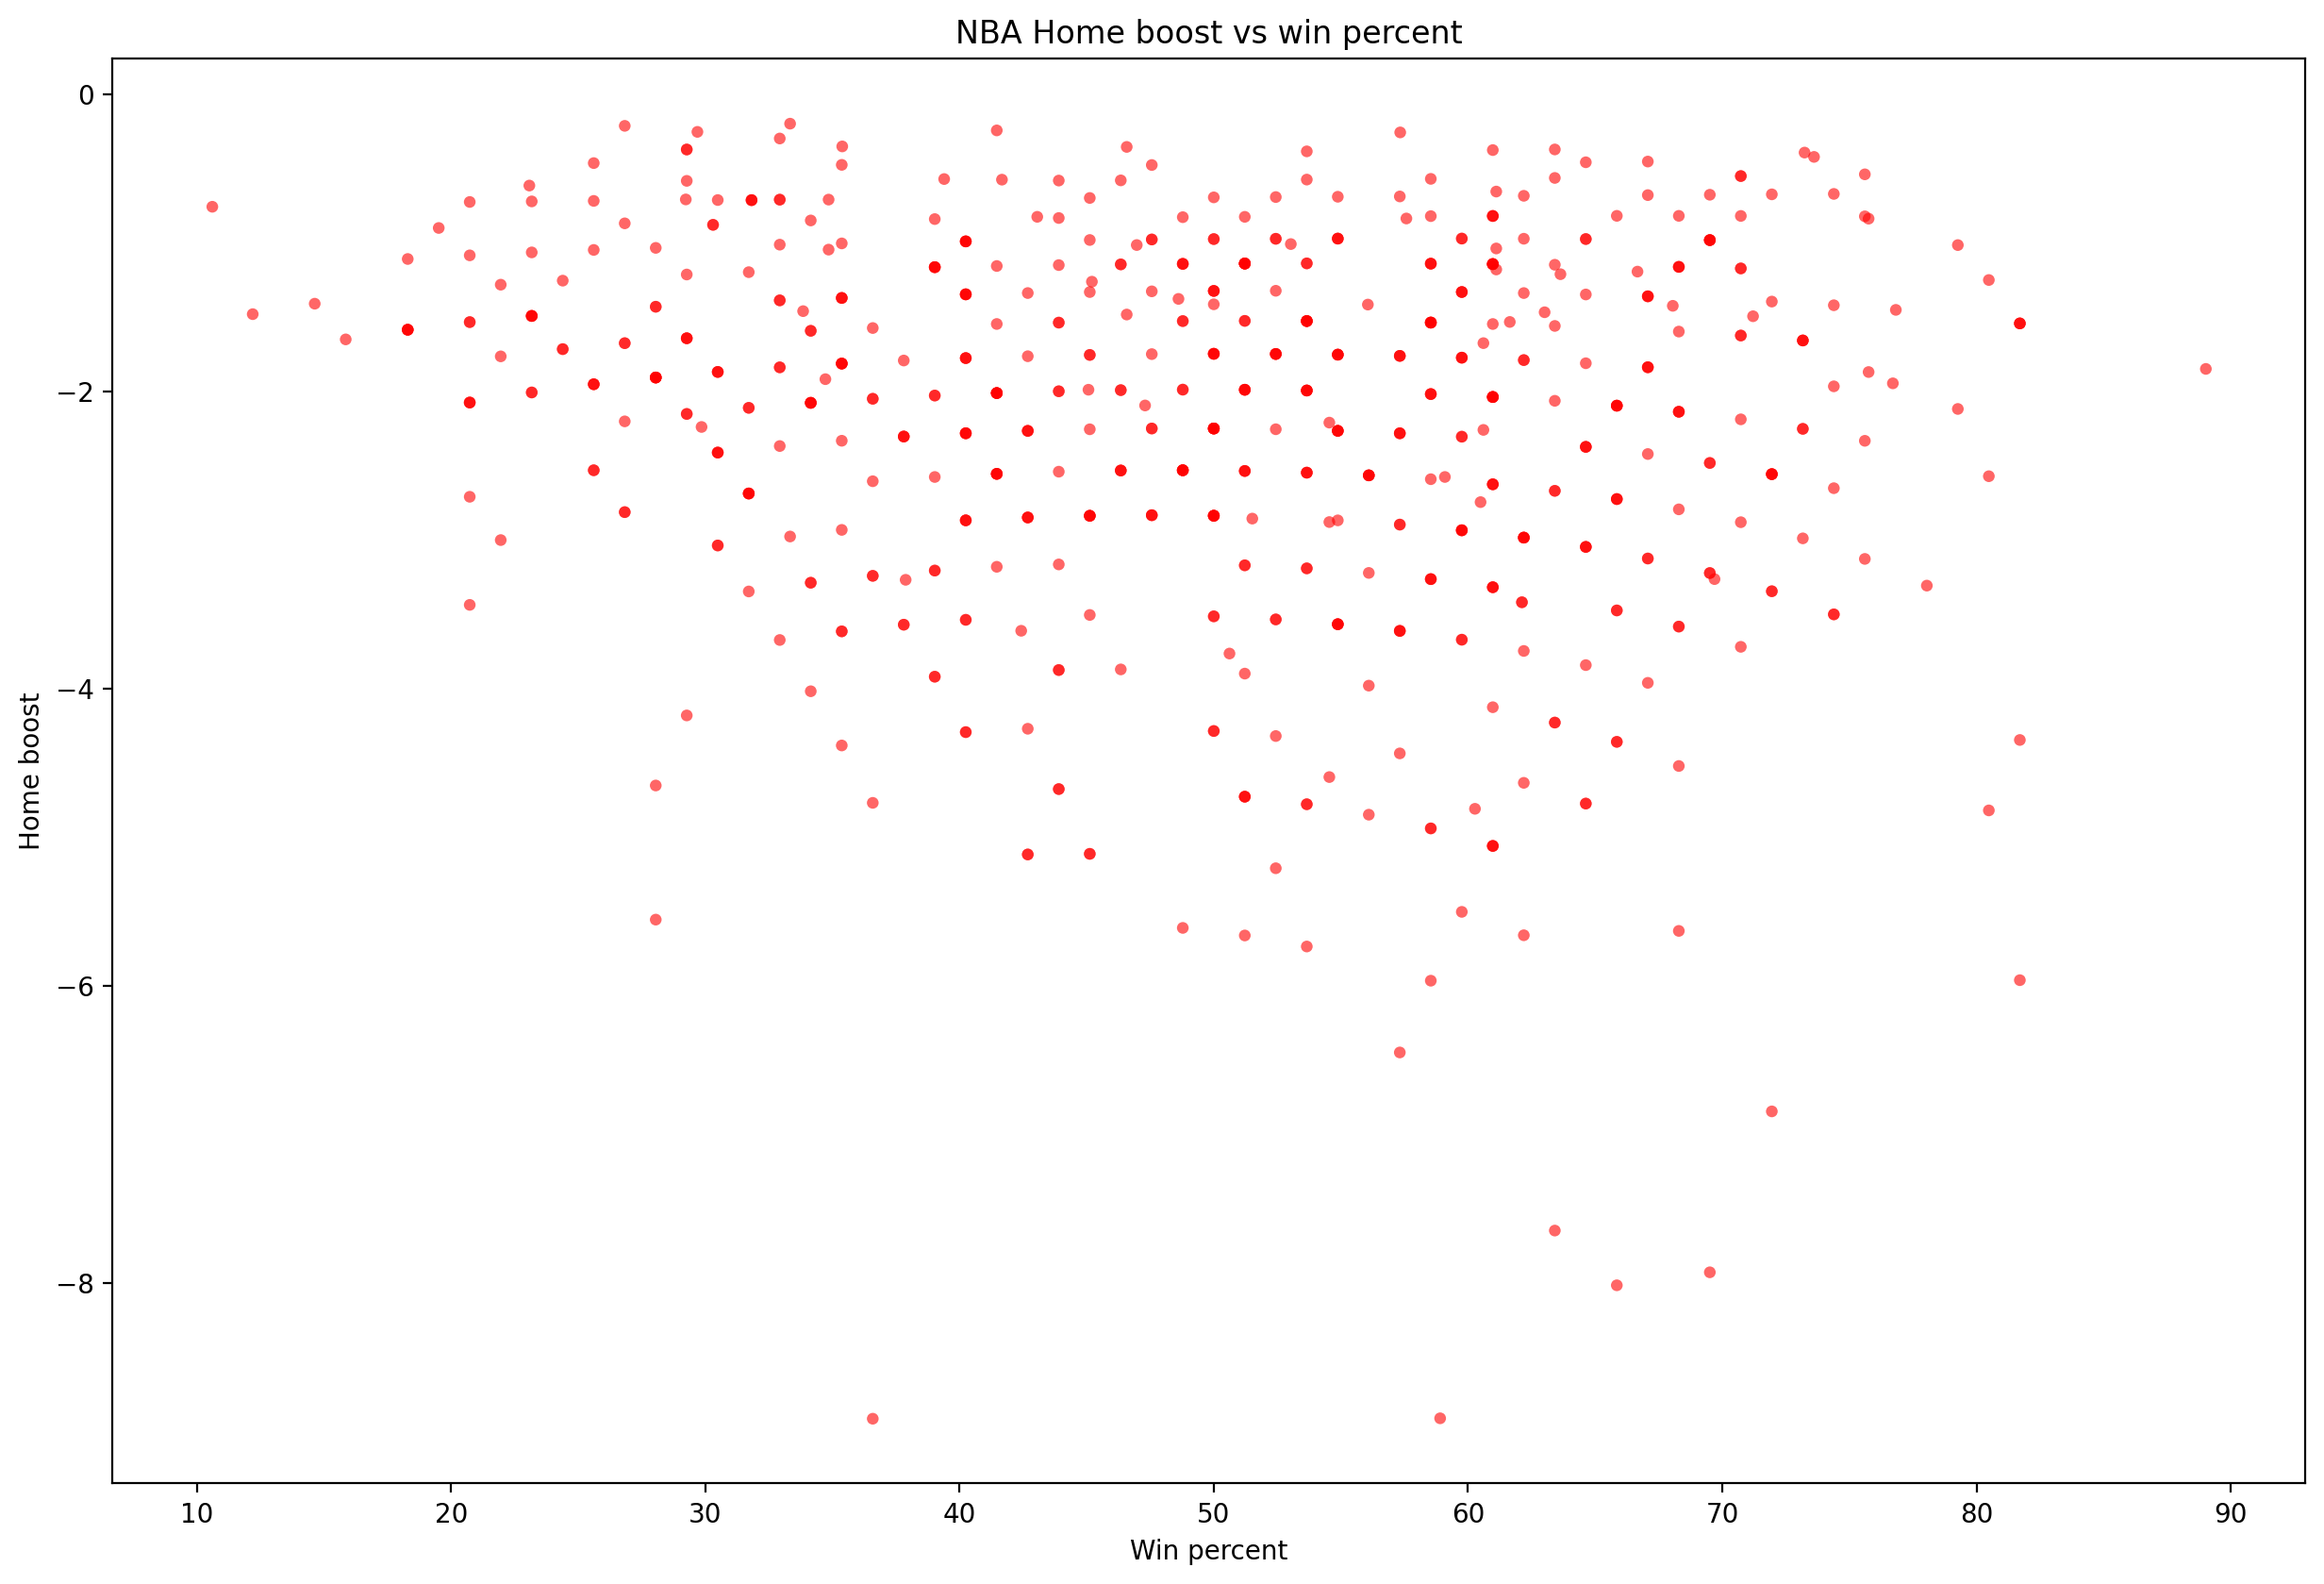

In [29]:
# Create plot
fig = plt.figure(figsize=(15, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
ax.set_ylabel("Home boost")
ax.set_xlabel("Win percent")


ax.scatter(np.array(all_win_pcts["nba"]) * 100, all_home_boosts["nba"], alpha=0.6, c="red", edgecolors='none', s=20)

plt.title('NBA Home boost vs win percent')
plt.savefig('nba_home_boost_vs_win_percent')
plt.show()
        

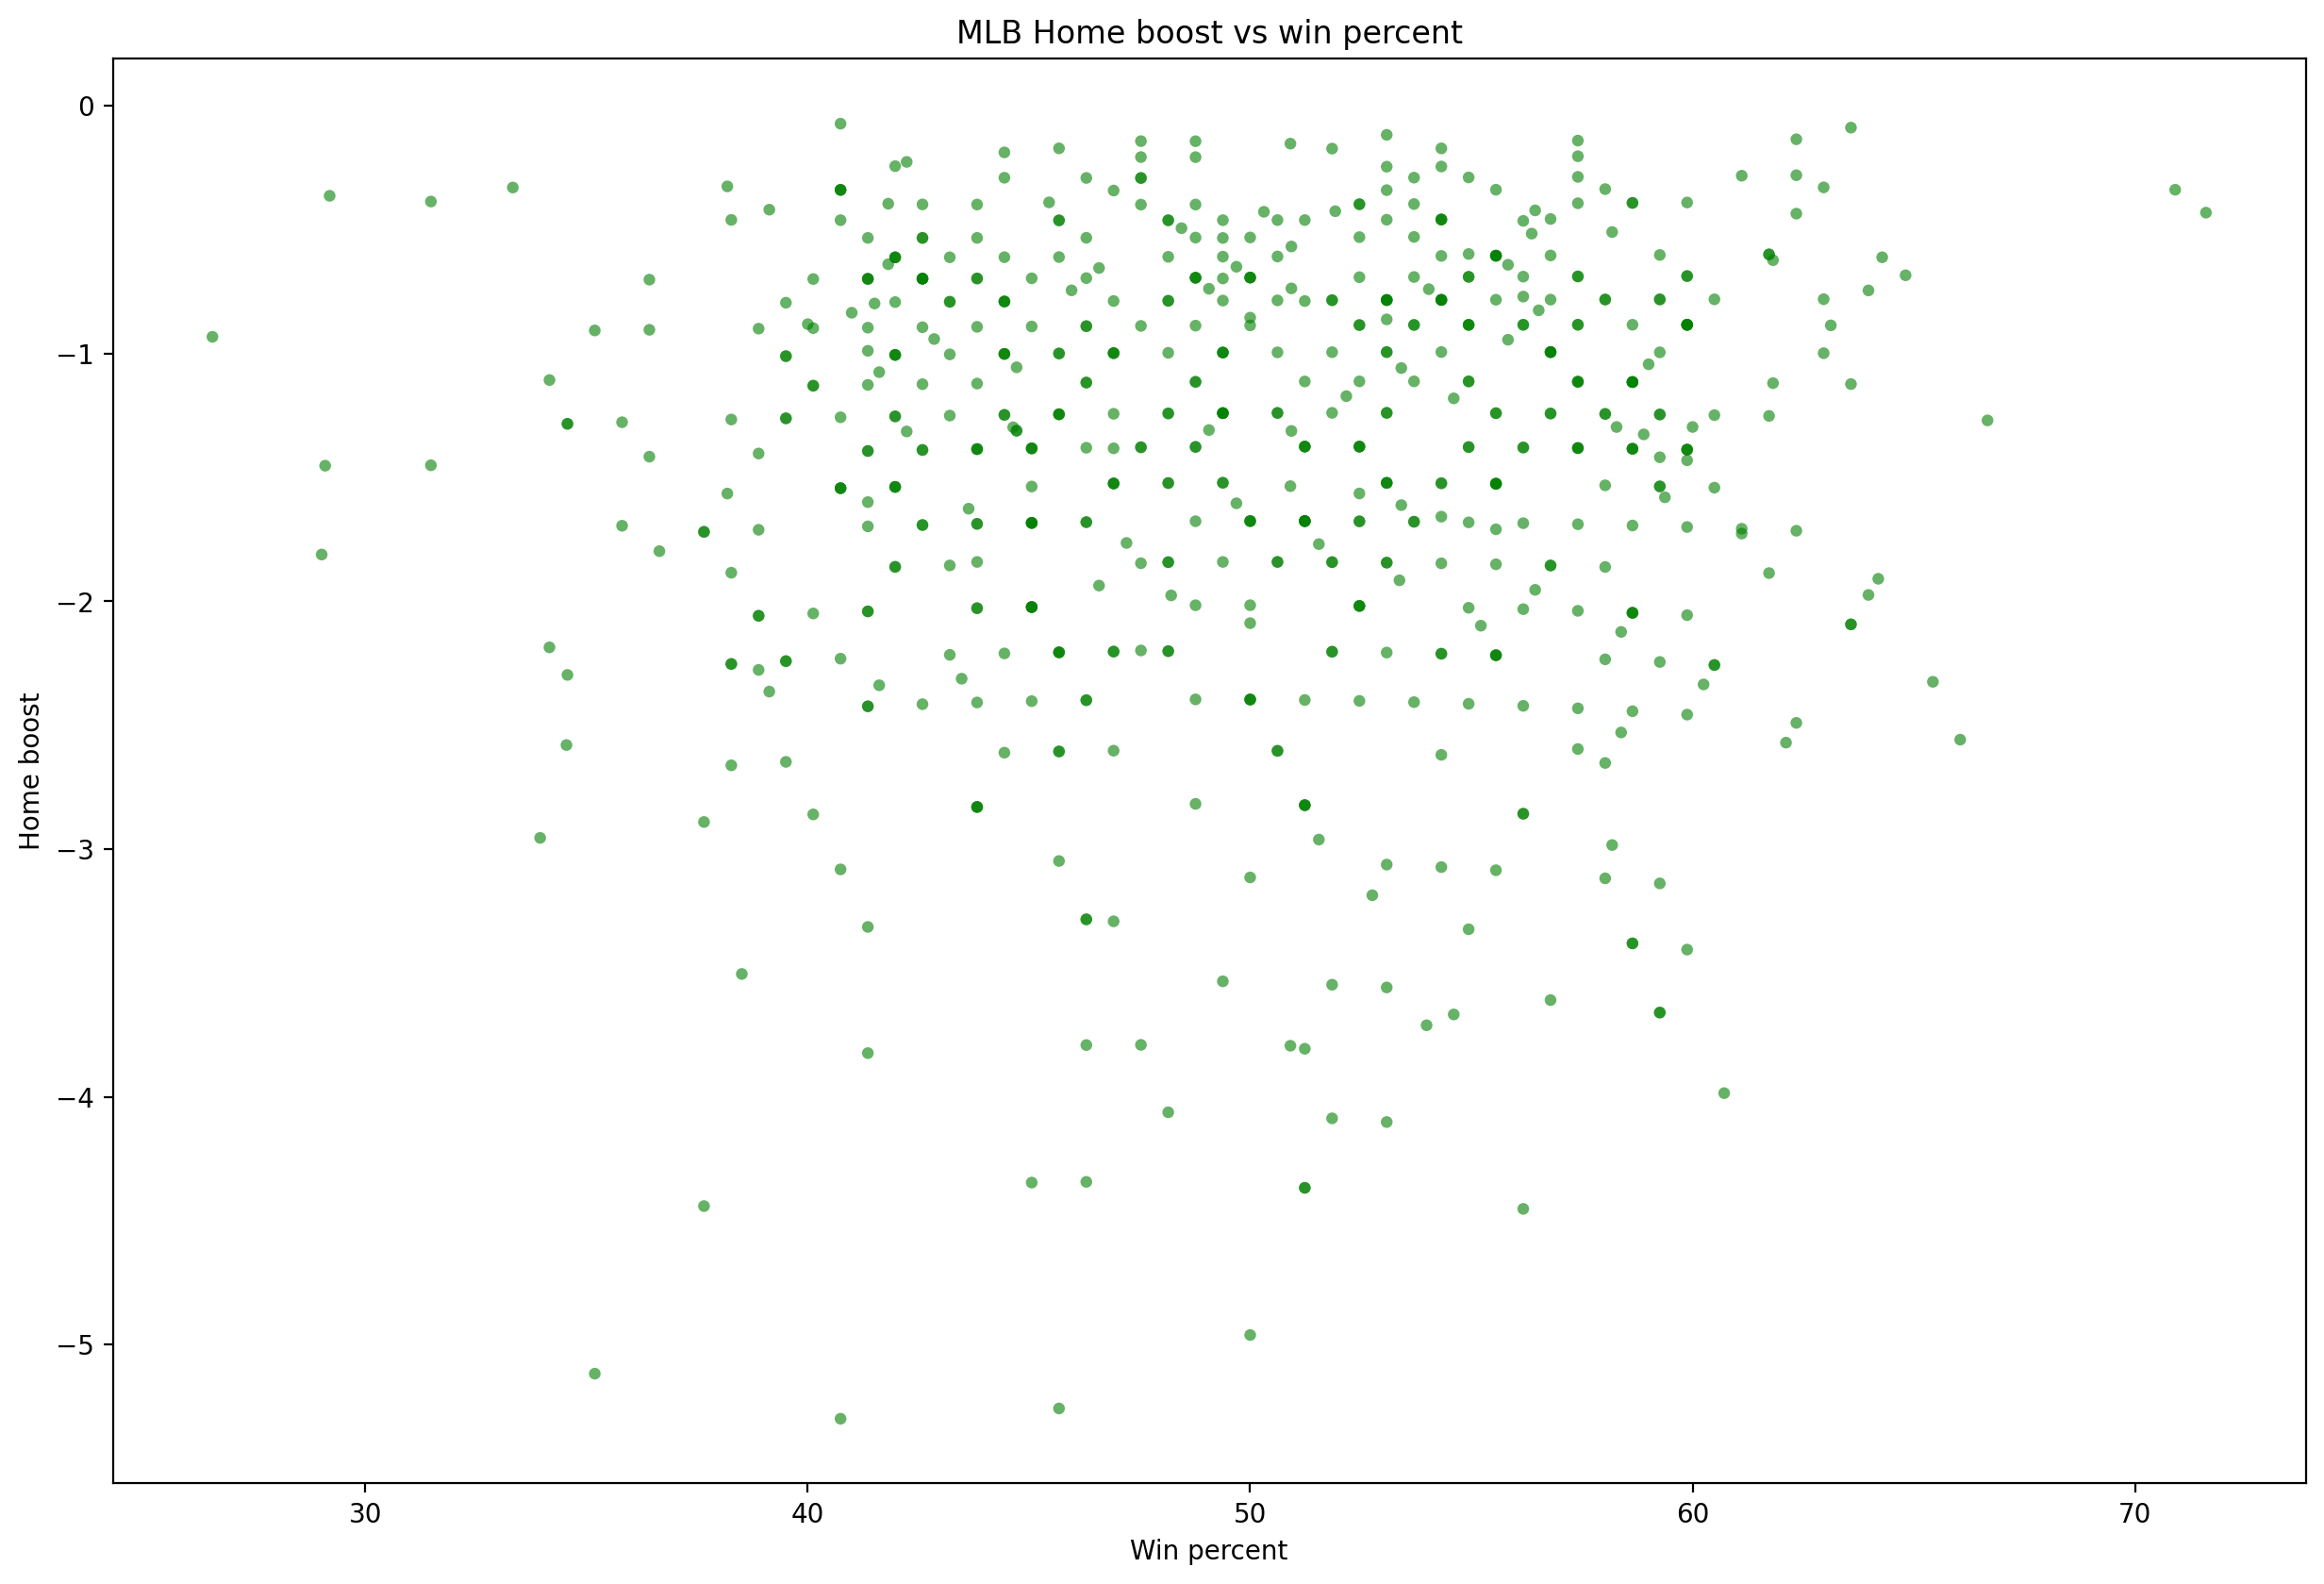

In [30]:
# Create plot
fig = plt.figure(figsize=(15, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
ax.set_ylabel("Home boost")
ax.set_xlabel("Win percent")


ax.scatter(np.array(all_win_pcts["mlb"]) * 100, all_home_boosts["mlb"], alpha=0.6, c="green", edgecolors='none', s=20)

plt.title('MLB Home boost vs win percent')
plt.savefig('mlb_home_boost_vs_win_percent')
plt.show()
        

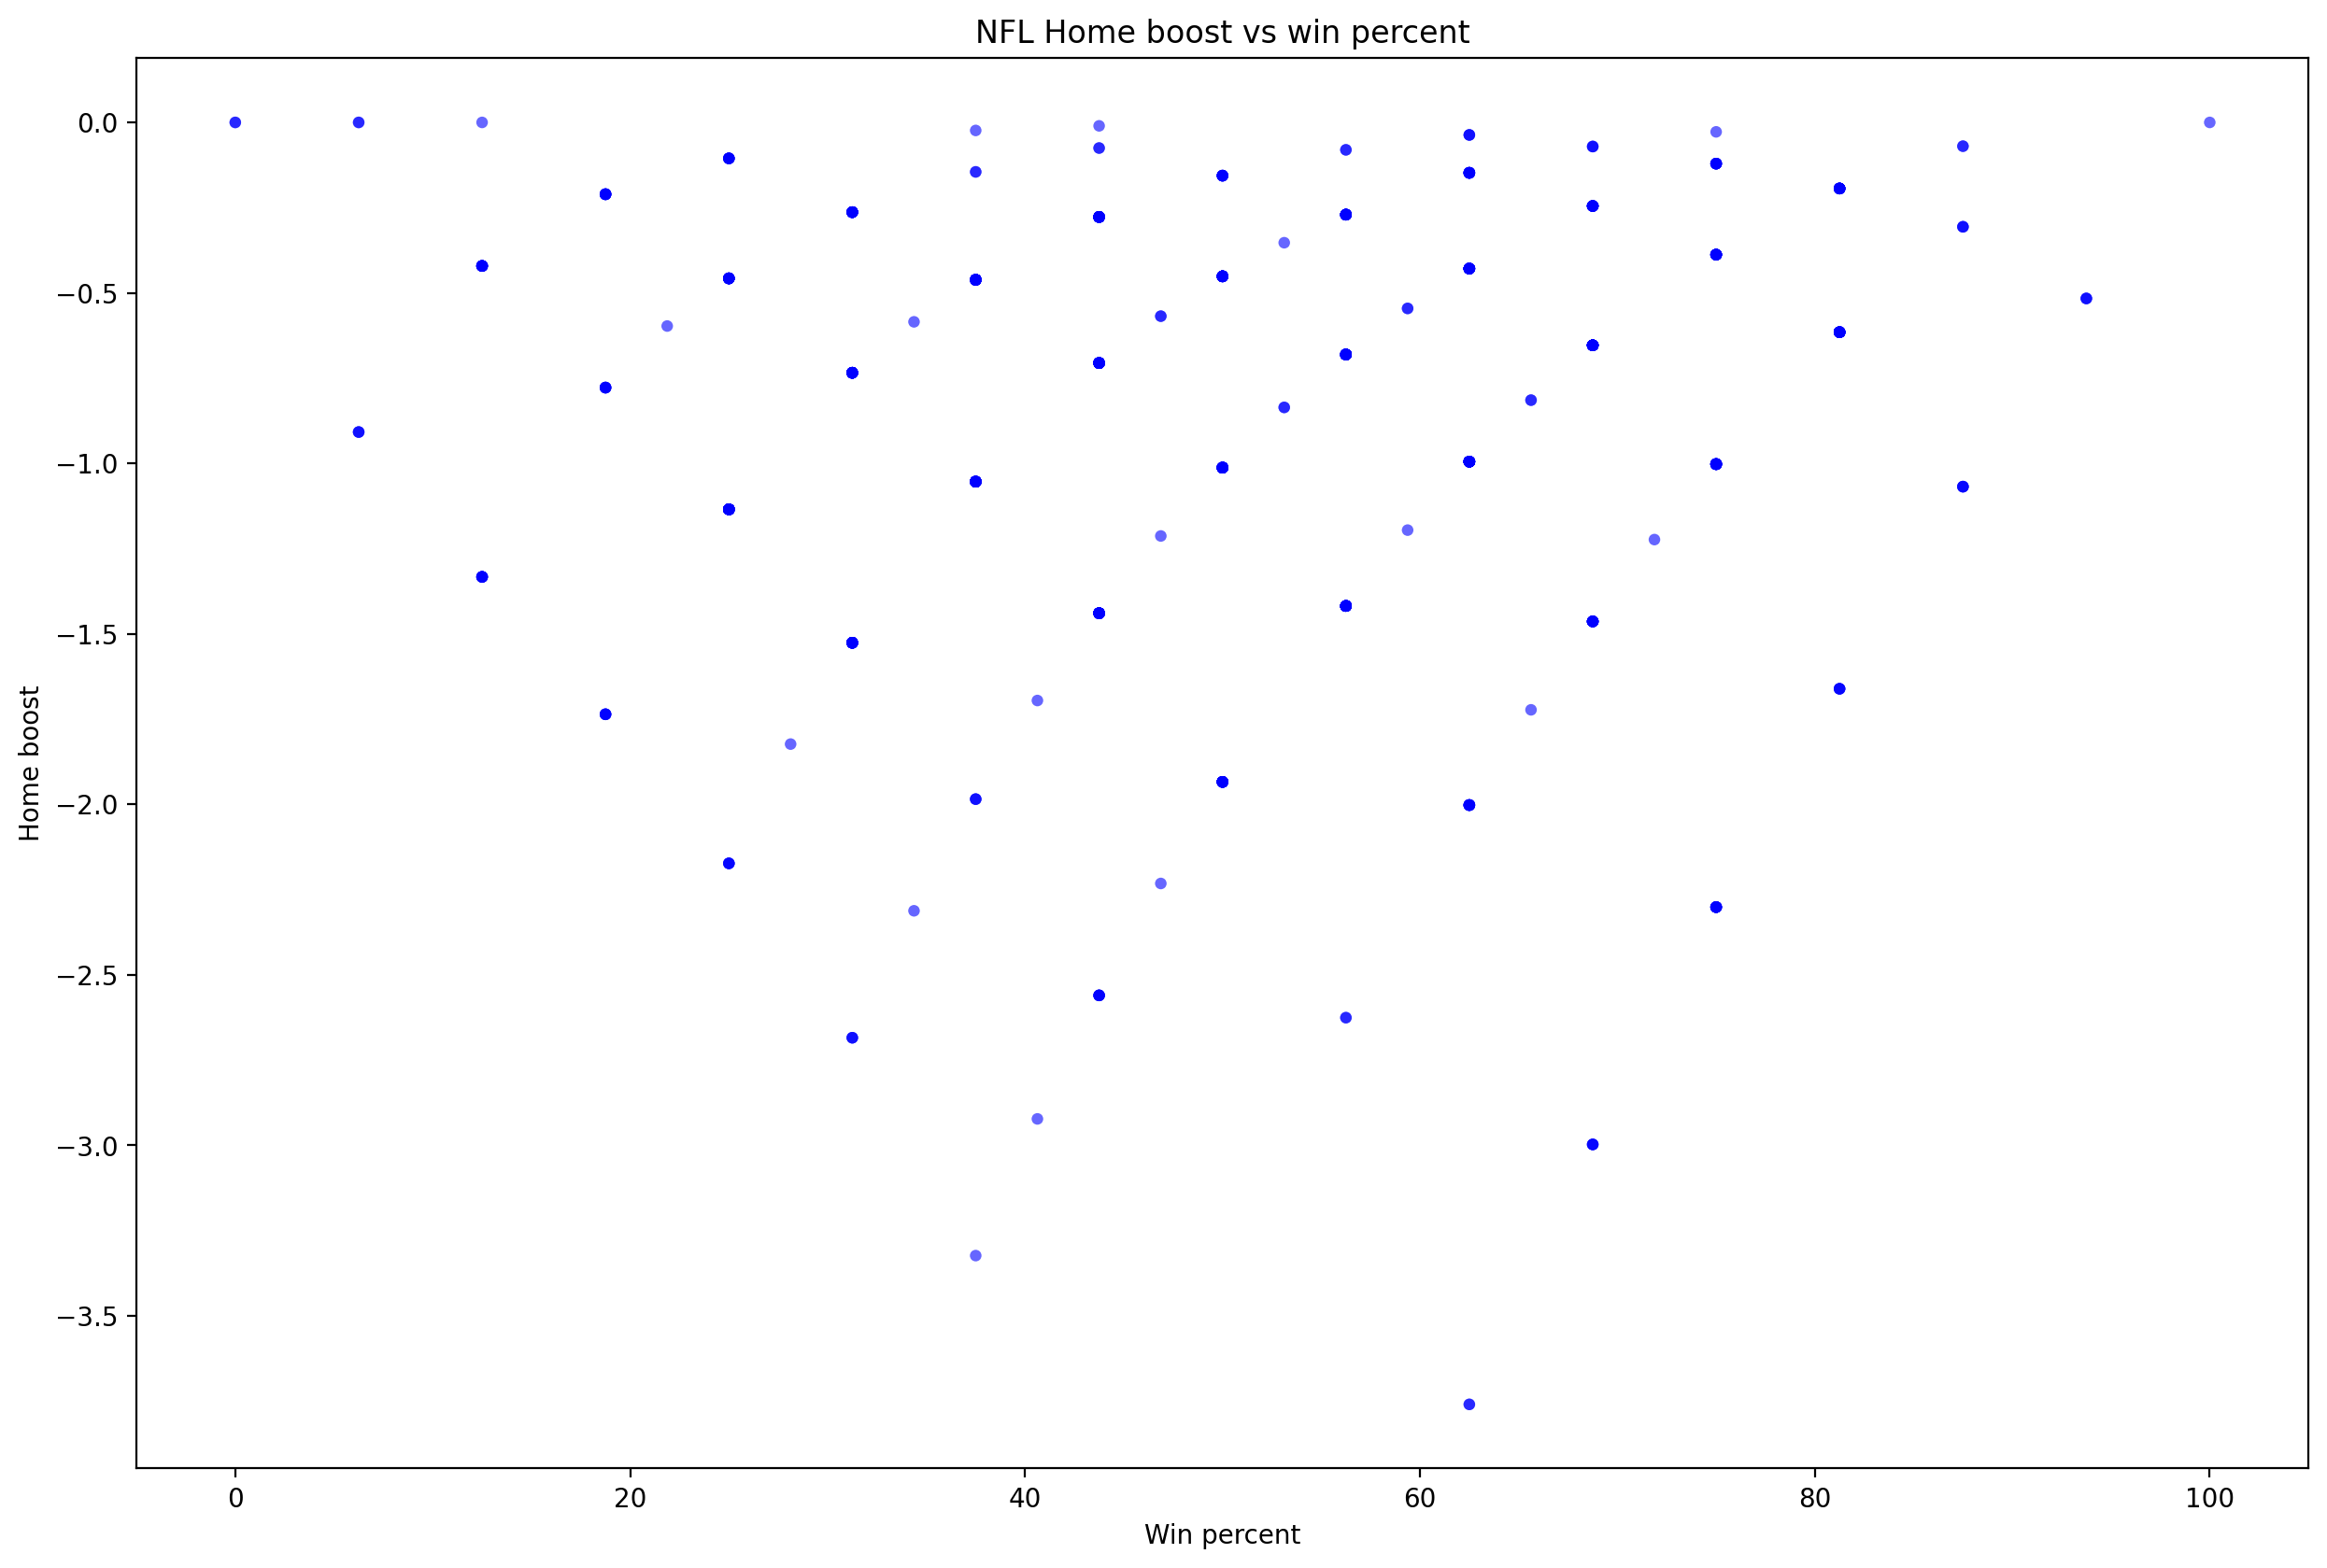

In [32]:
# Create plot
fig = plt.figure(figsize=(15, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
ax.set_ylabel("Home boost")
ax.set_xlabel("Win percent")


ax.scatter(np.array(all_win_pcts["nfl"]) * 100, all_home_boosts["nfl"], alpha=0.6, c="blue", edgecolors='none', s=20)

plt.title('NFL Home boost vs win percent')
plt.savefig('nfl_home_boost_vs_win_percent')
plt.show()
        

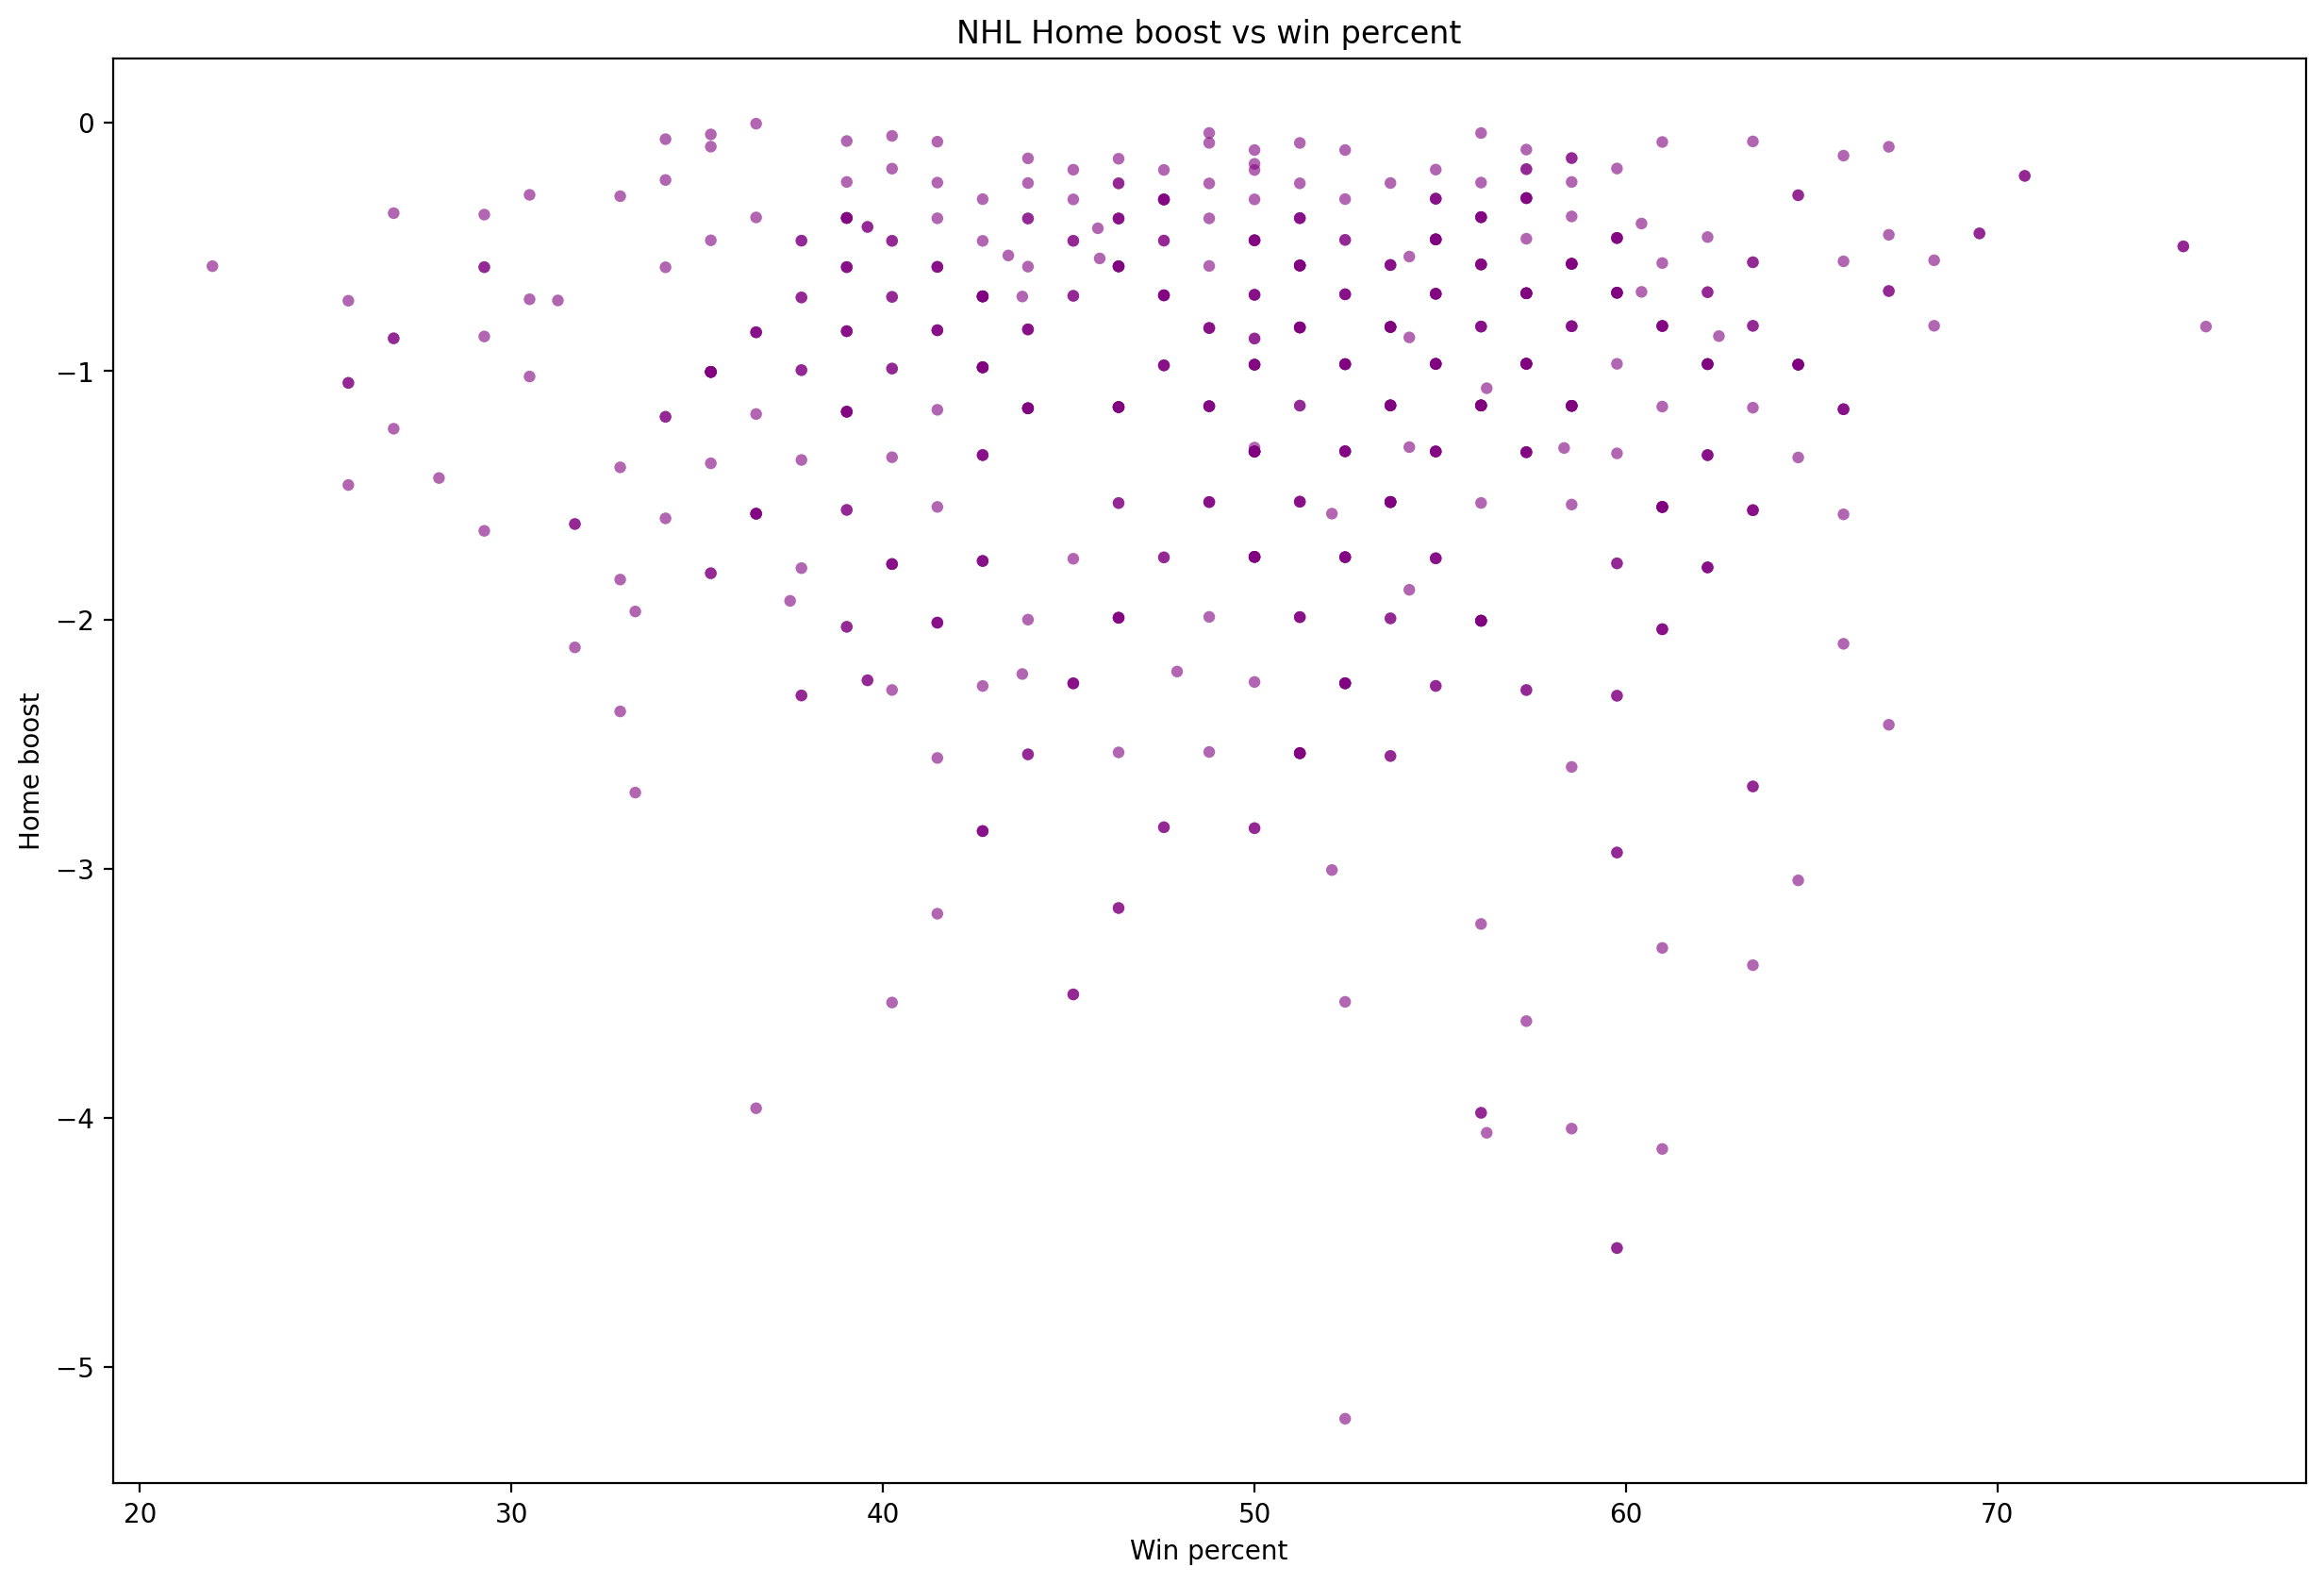

In [31]:
# Create plot
fig = plt.figure(figsize=(15, 10), dpi=200)
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
ax.set_ylabel("Home boost")
ax.set_xlabel("Win percent")


ax.scatter(np.array(all_win_pcts["nhl"]) * 100, all_home_boosts["nhl"], alpha=0.6, c="purple", edgecolors='none', s=20)

plt.title('NHL Home boost vs win percent')
plt.savefig('nhl_home_boost_vs_win_percent')
plt.show()
        

[(-2.3308600570990894, 'COL'), (-2.0917342366529064, 'TBD'), (-2.0369284301762707, 'MON')]
[(-1.2015413262213155, 'SEA'), (-1.167002183434528, 'LAA'), (-1.1538119689113608, 'NYM')]
[(-3.376986133908869, 'Denver Nuggets'), (-2.8304023653045216, 'Indiana Pacers'), (-2.8223822667282508, 'San Antonio Spurs')]
[(-1.7135300943272596, 'Seattle SuperSonics'), (-1.471184180597055, 'Brooklyn Nets'), (-1.3869181660869965, 'Vancouver Grizzlies')]
[(-1.247610057257289, 'Minnesota Vikings'), (-1.2461863394110329, 'Baltimore Ravens'), (-1.1586651658799665, 'Seattle Seahawks')]
[(-0.6130199669761432, 'Philadelphia Eagles'), (-0.3680213795417536, 'Los Angeles Rams'), (-0.3549249434612463, 'Los Angeles Chargers')]
[(-1.5792694645282472, 'Calgary Flames'), (-1.555223441547544, 'Vegas Golden Knights'), (-1.5388957949162745, 'Anaheim Ducks')]
[(-0.9422811045180297, 'Edmonton Oilers'), (-0.9005053522479436, 'New York Islanders'), (-0.8609439235021634, 'Atlanta Thrashers')]


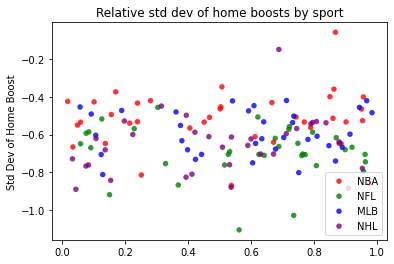

In [9]:
mlb_zipped = list(zip(mlb_means, mlb_labels))
mlb_zipped.sort()
print(mlb_zipped[:3])
print(mlb_zipped[-3:])

nba_zipped = list(zip(nba_means, nba_labels))
nba_zipped.sort()
print(nba_zipped[:3])
print(nba_zipped[-3:])

nfl_zipped = list(zip(nfl_means, nfl_labels))
nfl_zipped.sort()
print(nfl_zipped[:3])
print(nfl_zipped[-3:])

nhl_zipped = list(zip(nhl_means, nhl_labels))
nhl_zipped.sort()
print(nhl_zipped[:3])
print(nhl_zipped[-3:])

nba_norm = np.array(nba_std_devs) / np.array(nba_means)
nfl_norm = np.array(nfl_std_devs) / np.array(nfl_means)
nhl_norm = np.array(nhl_std_devs) / np.array(nhl_means)
mlb_norm = np.array(mlb_std_devs) / np.array(mlb_means)

#Referenced https://pythonspot.com/matplotlib-scatterplot/
data = (nba_norm, nfl_norm, mlb_norm, nhl_norm)
colors = ("red", "green", "blue", "purple")
groups = ("NBA", "NFL", "MLB", "NHL")

# Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
ax.set_ylabel("Std Dev of Home Boost")

for data, color, group in zip(data, colors, groups):
    ax.scatter(np.random.rand(len(data)), data, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Relative std dev of home boosts by sport')
plt.legend(loc=4)
plt.savefig('std_dev_boost_by_sport')
plt.show()

In [20]:
#Are there teams out of all leagues which consistently enjoy a larger home boost?
def computeOptimalClusters(testList):
    xList=[]
    yList=[]
    length=len(tuple(testList))
    list2=[]
    for i in range(1,length+1,1):
        cluster=KMeans(n_clusters=i)
        fit=cluster.fit(testList)
        list2.append([fit.inertia_, i])
    for i in list2:
        xList.append(i[1])
        yList.append(i[0])
    kn = KneeLocator(xList, yList, curve='convex', direction='decreasing')
    print(kn.knee)
    return(kn.knee)

def evaluateConsistency(testList):
    cluster=KMeans(n_clusters=computeOptimalClusters(testList), max_iter=10000, tol=.000000001,algorithm='auto')
    cluster.fit(testList)
    MeasureList=cluster.predict(testList)
    scatter([i[0] for i in testList],[i[1] for i in testList],c=MeasureList)
    minimum=min([index[1] for index in cluster.cluster_centers_])
    minIndex=[i for i in range(0,len(cluster.cluster_centers_)) if cluster.cluster_centers_[i][1]==minimum]
    selectList=[]
    for index,point in zip(MeasureList,testList):
        if(index==minIndex):
            selectList.append(point)
    return selectList

consistencyDict={}
consistencyList=[]
for league in teamHomeBoosts:
    for team in teamHomeBoosts[league]:
        if(len(teamHomeBoosts[league][team])>=2):
            variance=statistics.variance(teamHomeBoosts[league][team])
        
            mean=statistics.mean(teamHomeBoosts[league][team])
            if(mean<=0):
                consistencyDict[team]=[mean,variance]
                consistencyList.append([mean,variance])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])






-1.4390163112557597
9
7
Consistent high home boosts: 
[-1.7135300943272596, 0.42776039067617716] Seattle SuperSonics
[-1.7779924274765087, 0.6157135441788903] Toronto Raptors
[-1.471184180597055, 0.6857593767662269] Brooklyn Nets
[-1.4584714105614784, 0.564112660989192] SFG
[-1.43980941298216, 0.824523230827438] CHW
[-1.483274213444073, 0.8410130127713387] STL
[-1.538623415769982, 0.7152701624089012] OAK
[-1.5394543492123318, 0.43878716630043657] NYY
[-1.5205431931980988, 0.4323065925258201] TOR
[-1.4409707620104861, 0.8538168937780759] BAL
[-1.6664092482411896, 0.8267655562023609] TEX
[-1.4915516362807586, 0.9045335846769832] Tampa Bay Lightning
[-1.5388957949162745, 0.7360959890456762] Anaheim Ducks
[-1.555223441547544, 0.10888045585813846] Vegas Golden Knights
Consistent low home boosts: 
[-0.3680213795417536, 0.10540303296334232] Los Angeles Rams
[-0.3549249434612463, 0.08469397130221248] Los Angeles Chargers


In [ ]:
#which teams in the nba enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["nba"]:
    if(len(teamHomeBoosts["nba"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["nba"][team])
        mean=statistics.mean(teamHomeBoosts["nba"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])


In [ ]:
#which teams in the mlb enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["mlb"]:
    if(len(teamHomeBoosts["mlb"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["mlb"][team])
        mean=statistics.mean(teamHomeBoosts["mlb"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])

In [ ]:
#which teams in the nfl enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["nfl"]:
    if(len(teamHomeBoosts["nfl"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["nfl"][team])
        mean=statistics.mean(teamHomeBoosts["nfl"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])

In [ ]:
#which teams in the nhl enjoy consistent higher and lower home boosts?
consistencyDict={}
consistencyList=[]

for team in teamHomeBoosts["nhl"]:
    if(len(teamHomeBoosts["nhl"][team])>=2):
        variance=statistics.variance(teamHomeBoosts["nhl"][team])
        mean=statistics.mean(teamHomeBoosts["nhl"][team])
        if(mean<=0):
            consistencyDict[team]=[mean,variance]
            consistencyList.append([mean,variance])
                                   
                                   
scatter([index[0] for index in consistencyList],[index[1] for index in consistencyList])

meanSet=statistics.mean([item[0] for item in consistencyList])
print(meanSet)
greaterMeanList=[item for item in consistencyList if item[0]<meanSet]
lesserMeanList=[item for item in consistencyList if item[0]>meanSet]
consistentValuesLesser=evaluateConsistency(lesserMeanList)
consistentValuesGreater=evaluateConsistency(greaterMeanList)
print("Consistent high home boosts: ")
for i in consistentValuesGreater:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])
print("Consistent low home boosts: ")
for i in consistentValuesLesser:
    print(i,list(consistencyDict.keys())[list(consistencyDict.values()).index(i)])